In [1]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm
%load_ext autoreload
%autoreload 2

In [9]:
import os 
os.system("python3 main_traj.py --periods 5 --ppp 100")

0

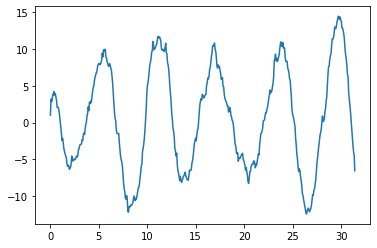

In [12]:
from visual_model import *

from misc import load_data, get_def_path

periods = 20
ppp=100
train_id = 0
defpath = get_def_path()
path = defpath+"{}periods/{}ppp/".format(periods,ppp)
means, covs, signals, coeffs = load_data(path)
tfsignals = tf.convert_to_tensor(signals)[tf.newaxis]
A,dt,C,D = coeffs
times = np.linspace(0,periods*2*np.pi, periods*ppp)
total_time = times[-1]
plt.plot(times, means[:,0])

In [13]:
rmodel = GRNNmodelVisual(coeffs = [C,D,dt, total_time], traj_details=[periods, ppp, train_id, path], cov_in=tf.convert_to_tensor(covs[0].astype(np.float32)), stateful=False)
rmodel.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01))
rmodel.recurrent_layer(tfsignals[:,:10,:], initial_state=rmodel.initial_state)
#rmodel.trainable_variables[0].assign(tf.convert_to_tensor(A.astype(np.float32)))

<tf.Tensor: shape=(1, 10, 2), dtype=float32, numpy=
array([[[ 0.12566371,  0.        ],
        [ 0.13823009, -0.01256637],
        [ 0.15079646, -0.02513274],
        [ 0.16336283, -0.03769911],
        [ 0.1759292 , -0.05026549],
        [ 0.18849559, -0.06283186],
        [ 0.20106196, -0.07539823],
        [ 0.21362834, -0.0879646 ],
        [ 0.22619471, -0.10053098],
        [ 0.23876108, -0.11309735]]], dtype=float32)>

In [5]:
rmodel.trainable_variables

[<tf.Variable 'rnn/stacked_rnn_cells/rcell/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[0.04047849]], dtype=float32)>]

In [6]:
parameters = np.linspace(0,5,100)

50000

In [23]:
dy[:,:,0]

<tf.Tensor: shape=(1, 499), dtype=float32, numpy=
array([[ 5.32826722e-01,  2.68072426e-01,  5.74027240e-01,
         8.36446702e-01,  5.62354445e-01,  8.39722753e-01,
         4.48343039e-01,  7.53438950e-01,  4.48729545e-01,
         4.42095250e-01,  1.02662623e-01,  4.84651923e-01,
         4.85357195e-01,  2.30421856e-01,  1.31862879e-01,
        -4.96157035e-02, -1.47540092e-01, -2.44290069e-01,
        -4.59132284e-01,  1.07922994e-01, -3.20047885e-01,
        -5.28233290e-01, -4.32137460e-01, -4.46305752e-01,
        -5.05675673e-01, -4.96629655e-01, -8.79325628e-01,
        -7.50432193e-01, -5.36834061e-01, -6.57936811e-01,
        -9.27223623e-01, -6.73281431e-01, -6.60894156e-01,
        -4.80560392e-01, -1.56534597e-01, -9.35769022e-01,
        -6.19360566e-01, -5.71121156e-01, -7.02739239e-01,
        -5.85620463e-01, -6.79196596e-01, -5.78173697e-01,
        -5.50888121e-01, -7.39684224e-01, -5.60413599e-01,
        -2.59445846e-01, -5.53072274e-01, -3.41751277e-01,
      

In [14]:
loss_values = {}

for length_series in [len(signals)]:

    l={}
    for th in tqdm(parameters):
        rmodel.trainable_variables[0].assign(tf.convert_to_tensor(np.array([[th]]).astype(np.float32)))
        dy = tfsignals[:,:length_series,:]
        l[th] = tf.keras.losses.MeanSquaredError()(dy,rmodel(dy)).numpy()
    loss_values[length_series] = np.array(list(l.values()))*(dy.shape[1]/total_time)


100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Text(0.5, 1.0, '$\\omega = 1$')

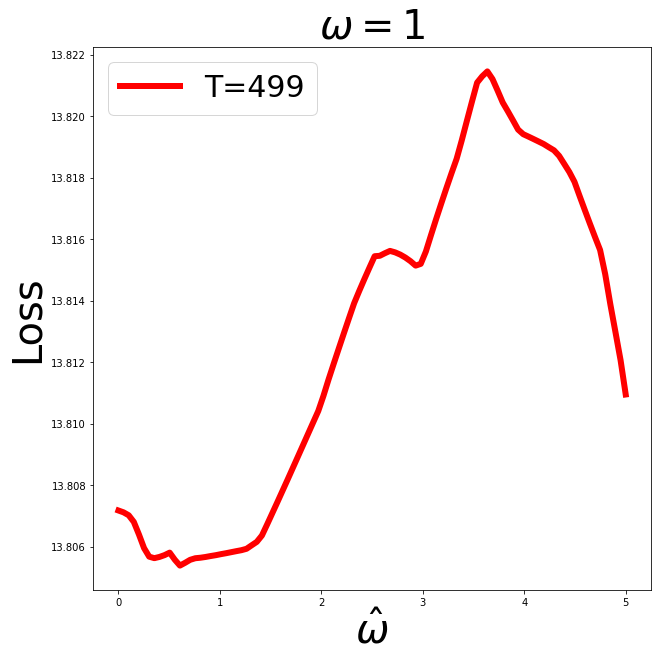

In [15]:
plt.figure(figsize=(10,10))
for ind,length_series in enumerate([len(signals)]):
    
    plt.plot(parameters, total_time*loss_values[length_series]/(dt*length_series), label="T=" + str(length_series), color=["red","blue","green"][ind], linewidth=6)
plt.xlabel(r'$\hat{\omega}$', size=40)
plt.ylabel("Loss",size=40)
plt.legend(prop={'size':30})
plt.title(r'$\omega = 1$',size=40)

In [16]:
tfmeans = tf.convert_to_tensor(means)

In [17]:
Cxdt = tf.einsum('ij,bj->bi',C,tfmeans)*dt

In [18]:
np.sum(np.square(Cxdt[:-1,0] - tfsignals[0,:,0]))

30.04486

In [25]:
loss_values = {}

for length_series in [len(signals)]:

    l={}
    for th in tqdm(parameters):
        rmodel.trainable_variables[0].assign(tf.convert_to_tensor(np.array([[th]]).astype(np.float32)))
        dy = tfsignals[:,:length_series,:]
        l[th] = tf.keras.losses.MeanSquaredError()(dy[:,:length_series,0],rmodel(dy)[:,:,0]).numpy()
    loss_values[length_series] = np.array(list(l.values()))*(dy.shape[1]/total_time)


100%|██████████| 100/100 [01:58<00:00,  1.19s/it]


Text(0.5, 1.0, '$\\omega = 1$')

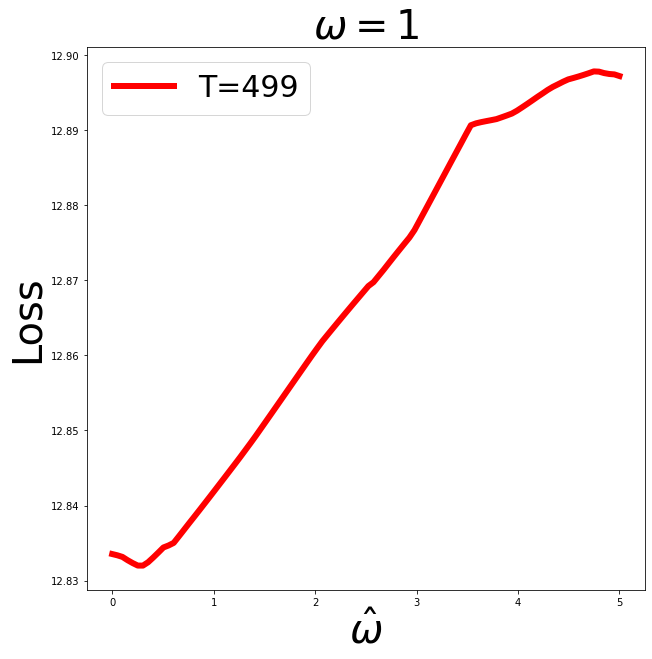

In [26]:
plt.figure(figsize=(10,10))
for ind,length_series in enumerate([len(signals)]):
    
    plt.plot(parameters, total_time*loss_values[length_series]/(dt*length_series), label="T=" + str(length_series), color=["red","blue","green"][ind], linewidth=6)
plt.xlabel(r'$\hat{\omega}$', size=40)
plt.ylabel("Loss",size=40)
plt.legend(prop={'size':30})
plt.title(r'$\omega = 1$',size=40)

In [ ]:
loss_values = {}

for length_series in [len(signals)]:

    l={}
    for th in tqdm(parameters):
        rmodel.trainable_variables[0].assign(tf.convert_to_tensor(np.array([[th]]).astype(np.float32)))
        dy = tfsignals[:,:length_series,:]
        l[th] = tf.keras.losses.MeanSquaredError()(dy[:,:length_series,1],rmodel(dy)[:,:,1]).numpy()
    loss_values[length_series] = np.array(list(l.values()))*(dy.shape[1]/total_time)




plt.figure(figsize=(10,10))
for ind,length_series in enumerate([len(signals)]):
    
    plt.plot(parameters, total_time*loss_values[length_series]/(dt*length_series), label="T=" + str(length_series), color=["red","blue","green"][ind], linewidth=6)
plt.xlabel(r'$\hat{\omega}$', size=40)
plt.ylabel("Loss",size=40)
plt.legend(prop={'size':30})
plt.title(r'$\omega = 1$',size=40)

 48%|████▊     | 48/100 [00:48<00:42,  1.23it/s]

In [45]:
a = np.zeros((1,10,2))
a[:,:,0] = 1
a[:,:,1] = 10
a = tf.convert_to_tensor(a)


b = np.zeros((1,10,2))
b[:,:,0] = 0.5
b[:,:,1] = 20
b = tf.convert_to_tensor(b)

In [51]:
tf.einsum('bij,bij->b',a-b,a-b)/20

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([50.125])>

In [50]:
tf.keras.losses.MeanSquaredError()(a,b)

<tf.Tensor: shape=(), dtype=float64, numpy=50.125>